In [1]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.special import erf, gamma, expn, hyp2f1, exp1

# 3 components: dark matter, gas, stars   
Fourier (used in power spectrum): $y_{i}(k|m)\ \equiv \frac{\hat{\rho_i}(k|m)\ }{m} $   
where $\hat{\rho_i}(k|m)\ $ is the Fourier of the real density profile (frequently numerical)

- Need to get $\hat{\rho_i}(k|m)\ $, the Fourier of the real density profile
    - so get the real density profile of it, then calculate the numerical (built-in) Fourier profile

In [3]:
### Set up eg- cosmo
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_k = np.geomspace(1E-2,9E1,100000) # np.geomspace(1E-3,1E2,100000)
trial_M = np.array([3E12,6E13, 1E14])/cosmo['h'] # trying with factor of h^{-1}

In [5]:
### From CCLX

# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef(200, 'matter')
# The Tinker 2008 mass function
hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m, mass_def_strict=False)
# The Tinker 2010 halo bias
hbf = ccl.halos.HaloBiasTinker10(mass_def=hmd_200m, mass_def_strict=False)
# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m)
# The NFW profile to characterize the matter density around halos
trial_nfwProf = ccl.halos.HaloProfileNFW(mass_def=hmd_200m, concentration=cM) # was pM = ...
hmc = ccl.halos.HMCalculator(mass_function=hmf_200m, halo_bias=hbf,mass_def=hmd_200m) # was hmc = ... 

## Stellar

- $\rho_*(x|m)=\frac{\rho_t}{x}\exp(-x^\alpha)$, with $x:=r/r_t$.
- Also: constraint on $\rho_t$ as require that the mass fraction overall is equal to the mass fraction within a halo.   
    - ie- $\frac{4 \pi}{\alpha} \rho_t r^3_t \left[ \Gamma(1 - \nu(\alpha )\ ) - x^2_{\Delta}\ E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) \right] = m\ f_*(m)\ $
    - where $x_{\Delta} = R_{\Delta}/r_t $, $\Gamma $ is the gamma function, $E_{\nu}(t)$ is the exponential integral of order $\nu $, & $ \nu({\alpha}) \equiv 1 - \frac{2}{\alpha}$
    - $E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) = $ scipy.special.expn( n = $\nu({\alpha}) $, x = $(x^{\alpha}_{\Delta}) $ )
        - so $v(\alpha )$ has to be an integer $n \ge 0$
        - So: $1 - \frac{2}{\alpha} \ge 0 \to \alpha \ge 2 $ AND $1 - \frac{2}{\alpha} $ must be an whole number
        - NOTE!! MAY BE PROBLEM IN ENFORCING THIS!
    - & $\Gamma(1 - \nu(\alpha )\ ) = $ scipy.special.gamma( z =  $(1 - \nu(\alpha ) $)
 
- ..
- $\rho_t = \frac{ m\ f_*(m)\ \alpha}{ 4 \pi r^3_t \left[ \Gamma(1 - \nu(\alpha )\ ) - x^2_{\Delta}\ E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) \right]}$
- BUT
    - $\rho_t = \frac{M f_*(M)\ }{4 \pi r_t^3}$ is used in CCLX
    - Upon inspection, these are the same for $\alpha = 1$ [$E_{\nu(\alpha)} = 0$ & $\Gamma(1 - \nu(\alpha)) = 1$ for $\alpha = 1$, so Fedeli reduces down to CCLX]

- The stellar mass fraction:
    - $f_*(m)=A\exp(-\frac{\log_{10}^2(m/m_{0s})}{2\sigma_s^2})$
    - NOTE: assuming that $log$ in Fedeli 2014 refers to $log10$, not $ln$
- Fix $A$ by requiring that $\bar{\rho}_*$ have a particular value:
    - $\bar{\rho}_*=\int_0^∞dmmf_*(m)n(m)$
    - where $n(m)$ is the halo mass function.
-  So $A = \frac{\bar{\rho}_*}{\int^{\infty}_0 dm\ m\ n(m)\ f_*(m)\ }$ (with $A$ not being included in $f_*(m)\ $ in the integral here obviously)

In [7]:
### some values that will be put in init (of StellarProfile) as self.X
### using values in CCLX code for trial 0
m_0s = 5E12/cosmo['h']
sigma_s = 1.2

# DM_mass_func = hmf_200m(cosmo,m,a_sf)/(m*np.log(10)) # under mf in def f_star_integrand(m)
hmd_200m = ccl.halos.MassDef(200, 'matter')
hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m, mass_def_strict=False)
# DM_mass_func = hmf_200m(cosmo, np.atleast_1d(trial_M), 1) / (np.atleast_1d(trial_M)*np.log(10))
# so want to move halo mass function into init, as need to generate DM_mass_func with the given halo's mass
rho_avg_star = 7E8*cosmo['h']**2 # under rho_star in CCLX

limInt_mStell = (1E10 , 1E15)  # mmin_stars=1E10, mmax_stars=1E15
# supposed to be (a,b) = (0,infty) BUT in reality can't practically use those limits

# alpha = 
# also want to have self.cosmo ?

In [9]:
class StellarProfile(ccl.halos.profiles.profile_base.HaloProfile):
    """ Stellar halo density profile. Fedeli (2014) arXiv:1401.2997
    """
    def __init__(self, cosmo, mass_def):
        ### will put in other parameters here later
        super(StellarProfile, self).__init__(mass_def=mass_def)
        self.cosmo = cosmo
     #   self.m_0s = 5E12 / self.cosmo['h']

    def _f_stell_noA(self, m):
        return np.exp( (-1/2) * ( np.log10(m/m_0s) /sigma_s )**2 )
    
    def _f_stell_integrand(self, m):
        # integrand = m * f_star(m) * n(m), where n(m,z) is the standard DM-only halo mass function
      #  DM_mass_func = hmf_200m(cosmo,m,a_sf)/(m*np.log(10)) # ? have as a self. ? (can't with scale_a, but-)
        DM_mass_func = hmf_200m(self.cosmo, np.atleast_1d(m), 1) / (np.atleast_1d(m)*np.log(10))
        return m* self._f_stell_noA(m) * DM_mass_func 
    
    # once we have A:   # f_star(m) = A*np.exp( (-1/2) * ( np.log10(m/m_0s) /omega_s )**2 )
    def _f_stell(self, m):
        # integrating over m (dm)
        integrad = integrate.quad(self._f_stell_integrand, limInt_mStell[0], limInt_mStell[1])
        A = rho_avg_star / integrad[0] #/ rho_avg_star
        return A * self._f_stell_noA(m)
    
    def _real(self, cosmo, r, M, scale_a=1, alpha = 1, r_t = 1, xDel_ratio = 1/0.03):
        """ X
        """
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # r_t = 
        r_vir = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a    # R_delta = the halo virial radius r_vir
        print(r_vir)
        f_stell = self._f_stell(M_use)
        
        if xDel_ratio is None:
            x_delta = r_vir / r_t # use the inputted value of r_c
        else:
            # default: x_delta = 1/0.03 # in CCLX example, as paper have for their eg: r_t / r_Delta = 0.03
            x_delta = xDel_ratio  # reassign r_c in order to give the specific r_c/r_Del ratio desired 
            r_t = r_vir / x_delta
            
        nu_alpha = 1 - (2 / alpha)
        # Using Tassia's E_1 = int^infty_1 e^{-xt} * t dt = (e^{-x}*(x+1))/(x^2), assuming x = alpha here
        rho_t_bracket = gamma(1 - nu_alpha) - (x_delta**2)*(x_delta**alpha)*(np.exp(-nu_alpha)*(nu_alpha+1))/(nu_alpha**2)
        rho_t = M_use*f_stell*alpha / (4*np.pi*(r_t**3) * rho_t_bracket)

        x = r_use[None, :] / r_t[:, None]
        prefix = rho_t * f_stell ## ASSUMING HERE that these are the prefix (relevant for [:, None] in next line)
        prof = prefix[:, None] * np.exp(-x**alpha)/x # (rho_t/x)*np.exp(-x** alpha) * f_stell
    # note: assuming that -x^alpha in eqn is meant to be -(x^alpha) (as code interprets it) as no brackets (for (-x)^alpha) in given eqn

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof


##### But for $\alpha=1$, if using $E_x = \int^{\infty}_1 e^{-xt}t dt = \frac{e^{-x}(x+1)}{x^2}$, with $x = \nu(\alpha)\ $
##### Then get $E_{\nu(1)} = 0$, reducing $\rho_t$ to $\frac{ m\ f_*(m)\ \alpha}{ 4 \pi r^3_t \left[ \Gamma(1 - \nu(\alpha )\ )\right]}$
##### And $ \Gamma(1 - \nu(\alpha )\ = 1$ for $\alpha = 1$

In [753]:
expn(-1, 2)
## see that expn does not work for negative n
## (maybe when trialing, set alpha = 2? (or ask, whichever 1st) )
gamma(1 - (1 - 2/1))
exp1(1 - 2/1)
exp1(1)

0.21938393439552062

In [755]:
# want to have r_t as its own parameter, made using r_Delta = virial radius

In [11]:
trial_stelProf = StellarProfile(cosmo, hmd_200m) # trying the mass_def CCLX used

In [13]:
trial_stel_real = trial_stelProf._real(cosmo, trial_r, trial_M)
trial_stel_real

[0.50052102 1.35862308 1.61082578]


array([[4.06951865e+13, 4.06795778e+13, 4.06639736e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.75342321e+13, 7.75120015e+13, 7.74897763e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.62018734e+13, 6.61834775e+13, 6.61650859e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

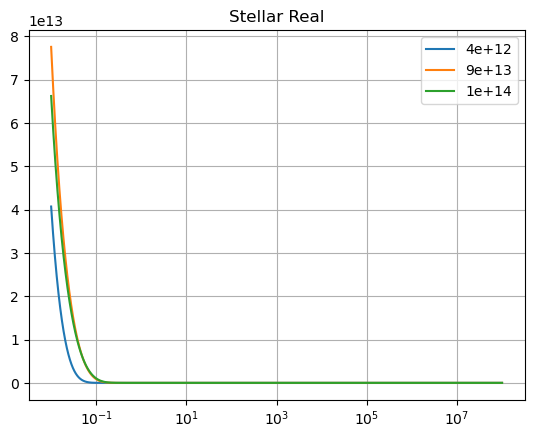

In [14]:
for mass, prof in zip(trial_M, trial_stel_real):
    plt.plot(trial_r, prof, label=f'{mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Stellar Real');

In [17]:
trial_stelProf.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,
                           n_per_decade=1000,plaw_fourier=-2.)
trial_stel_fourier = trial_stelProf.fourier(cosmo, trial_k, trial_M, 1)

[0.50052102 1.35862308 1.61082578]


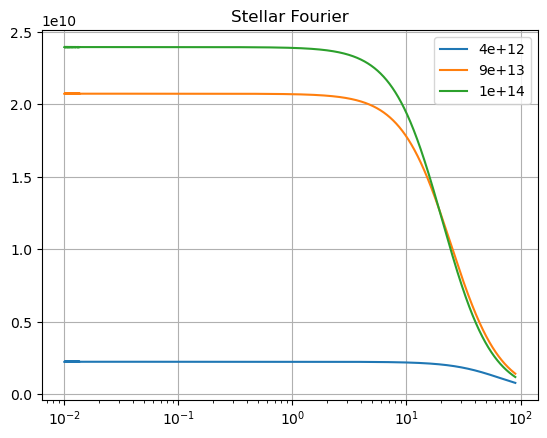

In [19]:
colours = ['tab:blue', 'orange', 'g']
for mass, prof, col in zip(trial_M, trial_stel_fourier, colours):
    plt.plot(trial_k, prof, label=f'{mass:.1g}')
   # plt.axhline(mass*trial_stelProf._f_stell(mass), color=col, linestyle='--');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Stellar Fourier');

In [21]:
trial_stelProf._f_stell(trial_M)

array([0.02288351, 0.01553537, 0.01293284])

## Gas

- The gas fraction in each halo approximately as:     
    - $f_g(m)=\frac{\Omega_b}{\Omega_m}\text{erf}\left[\frac{\log_{10}(m/m_{0g})}{\sigma_g}\right]$
    - for $m < m_{0g}$, we set $f_g\ = 0$

In [ ]:
def f_gas(m, ###
         m_0g= , sigma_g= 
         ):
    m_use = np.atleast_1d(m)
    f_array = np.zeros(np.shape(m_use))
    for i, mass in enumerate(m):
        if (mass < m_0g):
            f_array[i] = 0
        else:
            f_array[i] = (cosmo['Omega_b']/cosmo['Omega_m']) * erf(np.log10(mass/m_0g) / sigma_g)
    return f_array

In [23]:
### some values that will be put in init (of StellarProfile) as self.X
### using values in CCLX code for trial 0
m_0g = 5E12/cosmo['h']
sigma_g = 1.2

hmd_200m = ccl.halos.MassDef(200, 'matter')
#rho_avg_star = 7E8*cosmo['h']**2 # under rho_star in CCLX

# beta = 
# also want to have self.cosmo ?

- slightly different gas profile to Fedeli (2014) used in "Baryons_halo_model_power_spectrum" (CCLX):
    - $\rho_g(r)=\frac{\rho_{g,0}}{(1+u)^\beta(1+v^2)^{(7-\beta)/2}}$, with $u:=r/r_{co}$ and $v:=r/r_{ej}$.
- Fedeli 2014:
    - $\rho_g(r|m)=\frac{\rho_{c}}{(1+x^2)^{3\beta/2}}$, with $x:=r/r_{c}$
    - with the enforced relation of: $\frac{4}{3} \pi \rho_c r^3_c \left[ x_{\Delta}^3 ._2F_1 \left( \frac{3}{2}, \frac{3}{2}\beta, \frac{5}{2} ; -x^2_{\Delta} \right) \right] = m\ f_g(m)\ $
    - $x_{\Delta} = R_{\Delta}/r_c $
    - $._2F_1 \left( a, b, c; t \right) $ is the Gauss hypergeometric function $\to$ use scipy.special.hyp2f1(a, b, c, z, out=None)

### Fedeli uses: $\hat{\rho}_i(k|m) = 4 \pi R^3_{\Delta} \int^1_0 x^2\ dx\ \rho_i(R_{\Delta}x|m)\ j_0(kR_{\Delta}x)$    
where $j_0(t)$ is the zeroth-order spherical Bessel function ($ = sinh(t) = \frac{sin(t)}{t}$) & the Fourier integral gets truncated at the equivalent virial radius $R_{\Delta}$.      
[ In CCL, the Fourier eqn is: $\rho(k) = \frac{1}{2\pi} \int dr\ r^2\ \rho(r)\ j_0(kr) $ ].    
Compute Fourier using Fedeli's integral (then, when it works, implement Fourier interpolator for over the range of k).   
$\hat{\rho}_i(k|m) = 4 \pi R^2_{\Delta} \int^1_0 \sin(kR_{\Delta}x) / k x \rho_i(R_{\Delta}x|m)\ dx\ $


In [250]:
class GasProfile(ccl.halos.profiles.profile_base.HaloProfile):
    """ Gas halo density profile. Fedeli (2014) arXiv:1401.2997
    """
    def __init__(self, mass_def, fourier_numerical=True):
        ### will put in other parameters here later
        super(GasProfile, self).__init__(mass_def=mass_def)
        self.fourier_numerical = fourier_numerical
        if fourier_numerical is True:
            self._fourier = self._fourier_numerical

# want to have m_0g, sigma_g, & cosmo as self. in init
    def _f_gas(self, m):
        m_use = np.atleast_1d(m)
        f_array = np.zeros(np.shape(m_use))
        for i, mass in enumerate(m_use):
            if (mass < m_0g):
                f_array[i] = 0
            else:
                f_array[i] = (cosmo['Omega_b']/cosmo['Omega_m']) * erf(np.log10(mass/m_0g) / sigma_g)
        return f_array
    
    def _real(self, cosmo, r, M, scale_a=1, beta = 2/3, r_c = 1, xDel_ratio=1/0.05, truncate=False, # temporary param for truncating
              no_prefix=True): # no_prefix=False):
        """ X
        """
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # r_c = 
        r_vir = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a    # R_delta = the halo virial radius r_vir
        f_gas = self._f_gas(M_use)

        if xDel_ratio is None:
            x_delta = r_vir / r_c # use the inputted value of r_c
        else:
            # default: x_delta = 1/0.05 # in CCLX example, as paper have for their eg: r_c / r_Delta = 0.05
            x_delta = xDel_ratio  # reassign r_c in order to give the specific r_c/r_Del ratio desired 
            r_c = r_vir / x_delta

        rho_bracket = (x_delta**3) * hyp2f1(3/2, 3*beta/2, 5/2, -(x_delta**2))
        rho_c = 3 * M_use * f_gas / (4 * np.pi * (r_c**3) * rho_bracket)
        
        x = r_use[None, :] / r_c[:, None]

        if no_prefix is True:
            prof = 1/( (1 + x**2)**(3*beta/2) )
        else:
            prefix = rho_c * f_gas ## ASSUMING HERE that these are the prefix (relevant for [:, None] in next line)
            prof = prefix[:, None] / ((1 + x**2 )**(3 * beta / 2) )

        if truncate is True:
            for i, mass in enumerate(M_use):
                for j, radius in enumerate(trial_r):
                    if (radius > r_vir[i]):
                        # OR: could cut the array at the 1st r > r_vir, instead of inputting zeros (But leave for moment)
                        prof[i, j] = 0  # (should work as is)
            
        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof
    
    def _fourier_numerical(self, cosmo, k, M, scale_a=1, beta = 2/3, r_c = 1, xDel_ratio=1/0.05, no_prefix=True): # no_prefix=False):
        """ X
        """
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)

        # r_c = 
        r_vir = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a    # R_delta = the halo virial radius r_vir
        f_gas = self._f_gas(M_use)

        def fourier_integral(x, M, r_vir, cosmo=cosmo, scale_a=scale_a, beta = beta, xDel_ratio=xDel_ratio, no_prefix=no_prefix):
            """ Function to integrate for the Fedeli Fourier transform: 
        prof_fourier(k) = prof_real * x, integrated over x from 0 to 1, weighted by sin(k * R_delta * x) 
        & multiplied by prefix of 4*pi*R_delta^2 / k"""
            prof_real = self._real(cosmo, x*r_vir, M, scale_a=scale_a, beta = beta, xDel_ratio=xDel_ratio, no_prefix=no_prefix)
            integral = prof_real * x
            return integral

        # I0_array =  np.zeros((self.ngamma, self.nq)) # , dtype=object
        prof_array = np.zeros((len(np.atleast_1d(trial_M)),len(np.atleast_1d(trial_k))))
        for i, mass in enumerate(M_use):
            for j, k in enumerate(k_use):
                integrated = integrate.quad(fourier_integral, 0, 1, args=(mass, r_vir[i]), weight="sin", vwar=r_vir[i]*k)[0]
                prof_array[i,j] = integrated * 4 * np.pi * (r_vir[i] **2) / k

        # leaving out r_c & truncate default pars

        #######
   #     if xDel_ratio is None:
    #        x_delta = r_vir / r_c # use the inputted value of r_c
     #   else:
            # default: x_delta = 1/0.05 # in CCLX example, as paper have for their eg: r_c / r_Delta = 0.05
      #      x_delta = xDel_ratio  # reassign r_c in order to give the specific r_c/r_Del ratio desired 
       #     r_c = r_vir / x_delta

    #    rho_bracket = (x_delta**3) * hyp2f1(3/2, 3*beta/2, 5/2, -(x_delta**2))
    #    rho_c = 3 * M_use * f_gas / (4 * np.pi * (r_c**3) * rho_bracket)
        
    #    x = r_use[None, :] / r_c[:, None]

    #    if no_prefix is True:
    #        prof = 1/( (1 + x**2)**(3*beta/2) )
     #   else:
      #      prefix = rho_c * f_gas ## ASSUMING HERE that these are the prefix (relevant for [:, None] in next line)
       #     prof = prefix[:, None] / ((1 + x**2 )**(3 * beta / 2) )


        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

In [291]:
np.shape(trial_gas_real) == np.shape(np.ones((len(np.atleast_1d(trial_M)),len(np.atleast_1d(trial_k)))))

True

In [252]:
trial_gasProf = GasProfile(hmd_200m) # trying the mass_def CCLX used
trial_gas_real = trial_gasProf._real(cosmo, trial_r, trial_M)
trial_gas_real

array([[8.62316461e-01, 8.62261775e-01, 8.62207072e-01, ...,
        6.26880352e-20, 6.26591727e-20, 6.26303234e-20],
       [9.78789480e-01, 9.78779918e-01, 9.78770351e-01, ...,
        4.61889393e-19, 4.61676732e-19, 4.61464169e-19],
       [9.84818350e-01, 9.84811463e-01, 9.84804573e-01, ...,
        6.49287670e-19, 6.48988727e-19, 6.48689923e-19]])

In [234]:
r_vir_1 = trial_gasProf.mass_def.get_radius(cosmo, np.atleast_1d(trial_M), 1) 
for i, mass in enumerate(np.atleast_1d(trial_M)):
    for j, radius in enumerate(trial_r):
        if (radius > r_vir_1[i]):
            print(i, j, trial_gas_real[i, j]) # = 0

0 16995 0.0
0 16996 0.0
0 16997 0.0
0 16998 0.0
0 16999 0.0
0 17000 0.0
0 17001 0.0
0 17002 0.0
0 17003 0.0
0 17004 0.0
0 17005 0.0
0 17006 0.0
0 17007 0.0
0 17008 0.0
0 17009 0.0
0 17010 0.0
0 17011 0.0
0 17012 0.0
0 17013 0.0
0 17014 0.0
0 17015 0.0
0 17016 0.0
0 17017 0.0
0 17018 0.0
0 17019 0.0
0 17020 0.0
0 17021 0.0
0 17022 0.0
0 17023 0.0
0 17024 0.0
0 17025 0.0
0 17026 0.0
0 17027 0.0
0 17028 0.0
0 17029 0.0
0 17030 0.0
0 17031 0.0
0 17032 0.0
0 17033 0.0
0 17034 0.0
0 17035 0.0
0 17036 0.0
0 17037 0.0
0 17038 0.0
0 17039 0.0
0 17040 0.0
0 17041 0.0
0 17042 0.0
0 17043 0.0
0 17044 0.0
0 17045 0.0
0 17046 0.0
0 17047 0.0
0 17048 0.0
0 17049 0.0
0 17050 0.0
0 17051 0.0
0 17052 0.0
0 17053 0.0
0 17054 0.0
0 17055 0.0
0 17056 0.0
0 17057 0.0
0 17058 0.0
0 17059 0.0
0 17060 0.0
0 17061 0.0
0 17062 0.0
0 17063 0.0
0 17064 0.0
0 17065 0.0
0 17066 0.0
0 17067 0.0
0 17068 0.0
0 17069 0.0
0 17070 0.0
0 17071 0.0
0 17072 0.0
0 17073 0.0
0 17074 0.0
0 17075 0.0
0 17076 0.0
0 17077 0.0
0 17

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



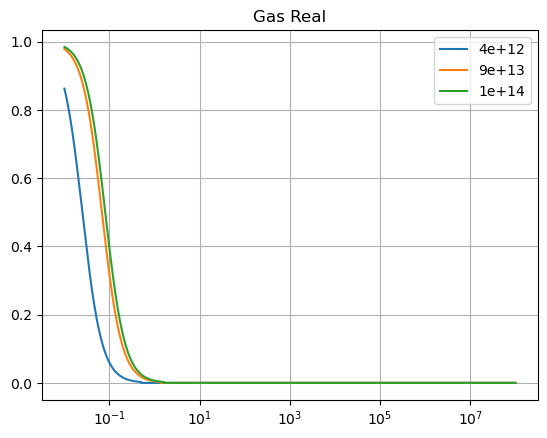

In [218]:
for mass, prof in zip(trial_M, trial_gas_real):
    plt.plot(trial_r, prof, label=f'{mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Gas Real');

In [132]:
trial_gasProf.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,
                           n_per_decade=1000,plaw_fourier=-2.) # should be fine to leave in with these updated parameters
trial_gas_fourier = trial_gasProf.fourier(cosmo, trial_k, trial_M, 1)

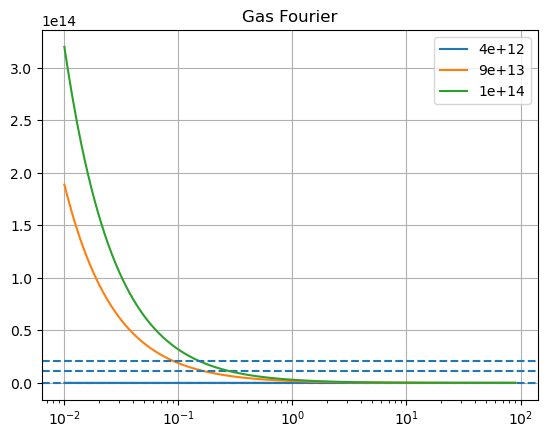

In [136]:
for mass, prof in zip(trial_M, trial_gas_fourier):
    plt.plot(trial_k, prof, label=f'{mass:.1g}');
    plt.axhline(mass*trial_gasProf._f_gas(mass), linestyle='--');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Gas Fourier');

### Checking shape of Gas & Analytical vs Numerical Fourier 

For $\beta = \frac{2}{3}$, $\rho_g(r|m)\ \to \rho_c\ \frac{1}{1 + x^2}$ & we can get the analytical Fourier transform.   
Want to look at shape of $\frac{1}{1 + x^2}$ / its Fourier to make sure it's correct.       
Adrien: Fourier for $\beta = \frac{2}{3}$ is $~ e^{-|k|} $   
So that $Log[f(k)] ~ -exp[Log(k)]$

In [37]:
# the numerical Fourier transform (using built-in CLL function):
trial_gas_fourier_noPrefix = trial_gasProf.fourier(cosmo, trial_k, trial_M, 1) #have created a (temporary) no_prefix=True default parameter
trial_gas_fourier_noPrefix

array([[1.23557771e+00, 1.23536040e+00, 1.23514944e+00, ...,
        1.44487156e-05, 1.44444538e-05, 1.44401930e-05],
       [9.09989805e+00, 9.09829695e+00, 9.09674252e+00, ...,
        2.78775316e-06, 2.78632104e-06, 2.78488973e-06],
       [1.27903012e+01, 1.27880505e+01, 1.27858654e+01, ...,
        1.81086012e-06, 1.81011176e-06, 1.80936390e-06]])

In [146]:
trial_gas_real_noPrefix = trial_gasProf._real(cosmo, trial_r, trial_M, no_prefix=True)
trial_gas_real_noPrefix[0]

array([8.62316461e-01, 8.62261775e-01, 8.62207072e-01, ...,
       6.26880352e-20, 6.26591727e-20, 6.26303234e-20])

In [154]:
for prof, mass in zip(trial_gas_real_noPrefix, trial_M):
    print(mass)

4285714285714.286
85714285714285.72
142857142857142.88


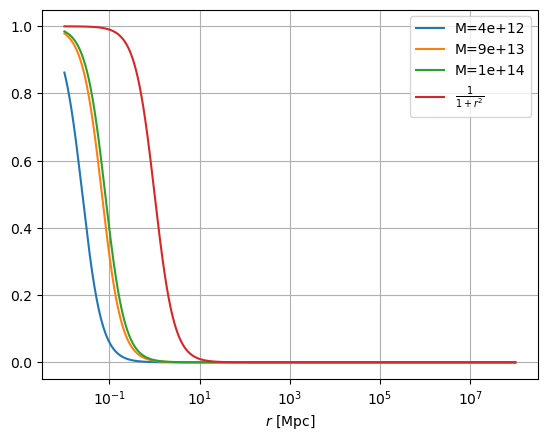

In [172]:
for prof, mass in zip(trial_gas_real_noPrefix, trial_M):
    plt.plot(trial_r, prof, label=f'M={mass:.1g}')
plt.plot(trial_r, 1/(1 + trial_r**2), label='$\\frac{1}{1+r^2}$');
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.grid(True)
#plt.yscale('log')
plt.xscale('log');
plt.xlabel(r'$r\, \,[{\rm Mpc}]$');

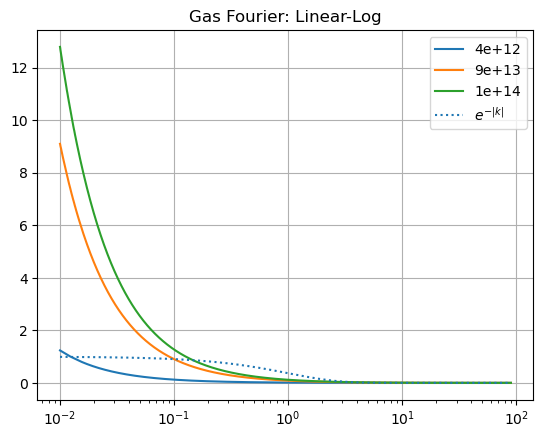

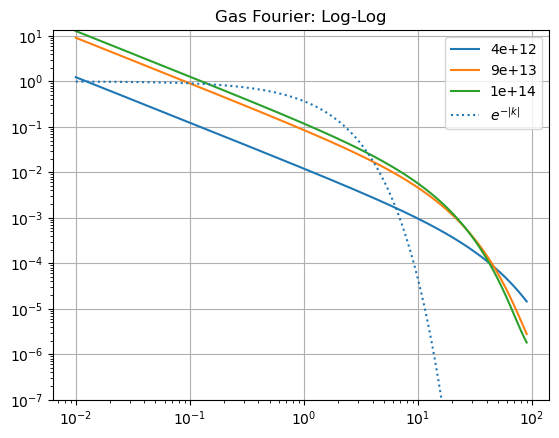

In [41]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_gas_fourier_noPrefix[i], color=colours[i], label=f'{mass:.1g}');
   # plt.plot(trial_k, np.exp(-np.abs(trial_k)), ':', label='$e^{-|k|}$')
   # plt.axhline(mass*trial_gasProf._f_gas(mass), color=colours[i], linestyle='--');
plt.plot(trial_k, np.exp(-np.abs(trial_k)), ':', label='$e^{-|k|}$')
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Gas Fourier: Linear-Log');

plt.figure()
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_gas_fourier_noPrefix[i], color=colours[i], label=f'{mass:.1g}');
plt.plot(trial_k, np.exp(-np.abs(trial_k)), ':', label='$e^{-|k|}$')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(1E-7)
plt.xscale('log')
plt.yscale('log')
plt.title('Gas Fourier: Log-Log');

## CAN SEE THAT CCL'S INBUILT DOESN'T REALLY MATCH WHAT THE ANALYTIC SHOULD BE (& adding in the np.exp(np.pi/2)) prefix doesn't help

### Fedeli truncated the Fourier integral at the equivalent virial radius $R_{\Delta}$.      
Try doing so with the real profile, then getting the inbuilt Fourier transform (as CCL's FFT has no option to just truncate the integral at a certain point).

In [174]:
help(trial_gasProf.fourier)
# can see no options in documentation for truncating the Fourier profile (at R_delta), SO: do temporary default parameter
# that sets the real profile to zero after R_Delta, Then get the inbuilt Fourier transform

Help on method fourier in module pyccl.halos.profiles.profile_base:

fourier(cosmo, k, M, a) method of __main__.GasProfile instance
    fourier(cosmo, k, M, a)
    Returns the Fourier-space value of the profile as a
    function of cosmology, wavenumber, halo mass and
    scale factor.

    .. math::
       \rho(k)=\frac{1}{2\pi^2} \int dr\, r^2\,
       \rho(r)\, j_0(k r)

    Args:
        cosmo (:class:`~pyccl.cosmology.Cosmology`): a Cosmology object.
        k (:obj:`float` or `array`): comoving wavenumber (in :math:`Mpc^{-1}`).
        M (:obj:`float` or `array`): halo mass.
        a (:obj:`float`): scale factor.

    Returns:
        (:obj:`float` or `array`): Fourier-space profile. The shape of the
        output will be ``(N_M, N_k)`` where ``N_k`` and ``N_m`` are
        the sizes of ``k`` and ``M`` respectively. If ``k`` or ``M``
        are scalars, the corresponding dimension will be
        squeezed out on output.



In [238]:
trial_gasProf.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,n_per_decade=1000,plaw_fourier=-2.)
trial_gas_fourier_truncate = trial_gasProf.fourier(cosmo, trial_k, trial_M, 1) #have created a (temporary) truncate=True default parameter
trial_gas_fourier_truncate

[[9.99999840e-01 9.99999840e-01 9.99999839e-01 ... 7.81131650e-14
  7.77162677e-14 7.73213870e-14]
 [9.99999978e-01 9.99999978e-01 9.99999978e-01 ... 5.75542721e-13
  5.72618356e-13 5.69708850e-13]
 [9.99999985e-01 9.99999985e-01 9.99999984e-01 ... 8.09052552e-13
  8.04941710e-13 8.00851757e-13]]


IndexError: index 16995 is out of bounds for axis 1 with size 9000

In [244]:
np.shape(trial_k) == np.shape(trial_r)

True

## Dark Matter

- Real density profile = NFW: $\rho_{DM}(x|m)\ = \frac{\rho_s}{x(1+x)^2} $
- where:
    - $x = r/r_s $
    - $\rho_s = $ the scale density of the profile
    - $r_s = $ the scale radius of the profile
- Also concentration $c \equiv R_{\Delta}/r_s$
- Constraint on scale density $\rho_s $ requires that the total DM mass w/in the structure matches the DM mass fraction
    - $\rho_s = f_{DM}\ \frac{\Delta}{3} \bar{\rho_m} \frac{c^3}{G(c)\ } $ , where $G(c)\ $ is the "usual NFW concentration function"

In [149]:
# The NFW profile to characterize the matter density around halos
help(trial_nfwProf._fourier)

Help on method _fourier_analytic in module pyccl.halos.profiles.nfw:

_fourier_analytic(cosmo, k, M, a) method of pyccl.halos.profiles.nfw.HaloProfileNFW instance



------------------------------------------------
Just go with NFW profile for the dark matter profile, so that:
- $\rho_{DM}(r|m)\ = \rho_{NFW}(r|m)\ * f_{DM}$
- Dark matter mass fraction: $f_{DM}(m, z)\ = 1 - \frac{ \Omega_{b,0} }{ \Omega_{m,0} } $

In [57]:
trial_nfw_real = trial_nfwProf._real(cosmo, trial_r, trial_M, 
                                     1)
trial_nfw_fourier = trial_nfwProf._fourier(cosmo, trial_k, trial_M, 
                                           1)

trial_nfw_real

array([[6.21968667e+15, 6.21778528e+15, 6.21588437e+15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53460065e+16, 1.53420944e+16, 1.53381832e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.75402850e+16, 1.75358926e+16, 1.75315011e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [59]:
f_dm = 1 - cosmo['Omega_b'] / cosmo['Omega_m']
f_dm

0.8333333333333333

In [61]:
trial_dm_real = f_dm * trial_nfw_real
trial_dm_fourier = f_dm * trial_nfw_fourier

trial_dm_real

array([[5.18307222e+15, 5.18148773e+15, 5.17990365e+15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.27883388e+16, 1.27850787e+16, 1.27818194e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.46169042e+16, 1.46132438e+16, 1.46095843e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

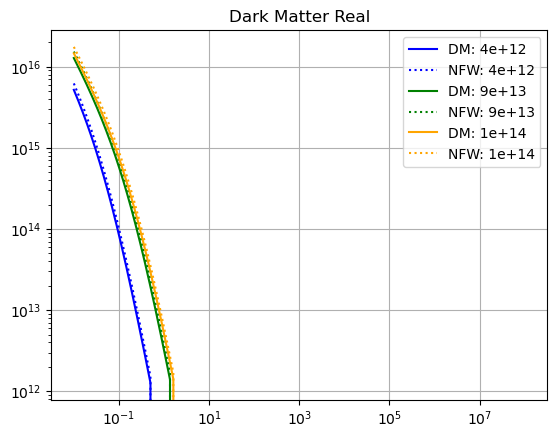

In [63]:
colours = ['b', 'g', 'orange']
for mass, prof, nfw, col in zip(trial_M, trial_dm_real, trial_nfw_real, colours):
    plt.plot(trial_r, prof, color=col, label=f'DM: {mass:.1g}');
    plt.plot(trial_r, nfw, ':', color=col, label=f'NFW: {mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title('Dark Matter Real');

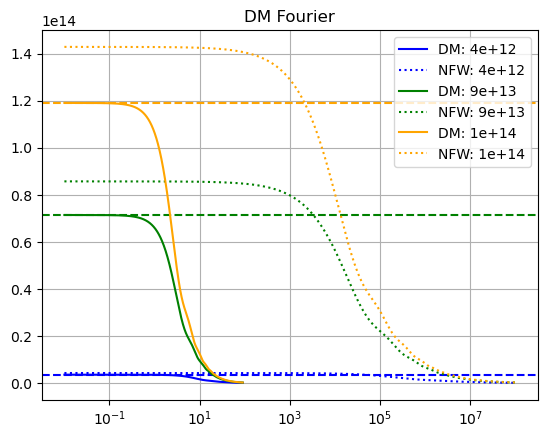

In [65]:
colours = ['b', 'g', 'orange']
for mass, prof, nfw, col in zip(trial_M, trial_dm_fourier, trial_nfw_fourier, colours):
    plt.plot(trial_k, prof, color=col, label=f'DM: {mass:.1g}');
    plt.axhline(mass*f_dm, color=col, linestyle='--');
    plt.plot(trial_r, nfw, ':', color=col, label=f'NFW: {mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('DM Fourier');

# Combine the profiles into 1 (sum)

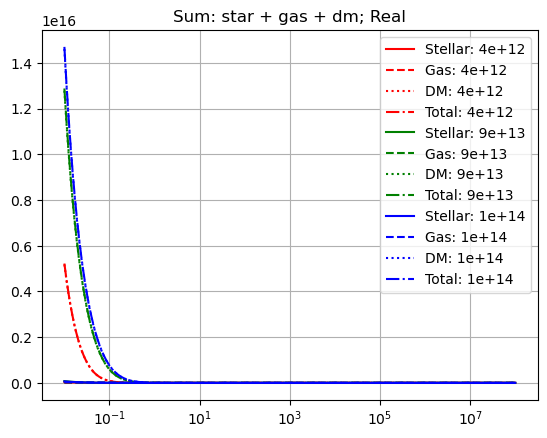

In [67]:
colours = ['r', 'g', 'b', 'k']
for mass, stel, gas, dm, col in zip(trial_M, trial_stel_real, trial_gas_real, trial_dm_real, colours):
    plt.plot(trial_r, stel, '-', color=col, label=f'Stellar: {mass:.1g}');
    plt.plot(trial_r, gas, '--', color=col, label=f'Gas: {mass:.1g}');
    plt.plot(trial_r, dm, ':', color=col, label=f'DM: {mass:.1g}');
    plt.plot(trial_r, dm+stel+gas, '-.', color=col, label=f'Total: {mass:.1g}');
    plt.legend(loc='best')
    plt.grid(True)
    plt.xscale('log')
    plt.title('Sum: star + gas + dm; Real');
   # plt.figure()

In [69]:
trial_sum_real = trial_stel_real + trial_gas_real + trial_dm_real
trial_sum_fourier = trial_stel_fourier + trial_gas_fourier + trial_dm_fourier

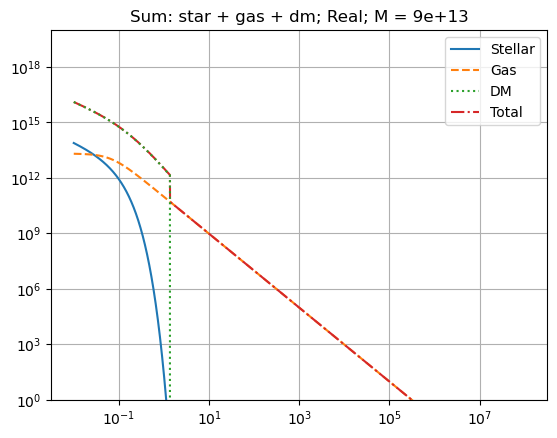

In [71]:
colours = ['r', 'g', 'b', 'k']
i = 1
plt.plot(trial_r, trial_stel_real[i], '-', label='Stellar');
plt.plot(trial_r, trial_gas_real[i], '--', label='Gas');
plt.plot(trial_r, trial_dm_real[i], ':', label='DM', zorder=5);
plt.plot(trial_r, trial_sum_real[i], '-.', label='Total');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1E0, 1E20)
plt.title(f'Sum: star + gas + dm; Real; M = {trial_M[i]:.1g}');

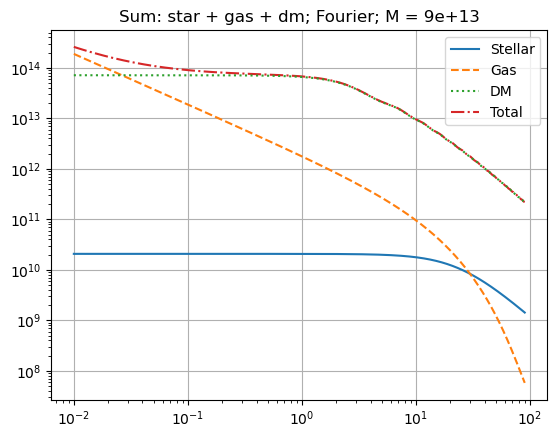

In [73]:
colours = ['r', 'g', 'b', 'k']
i = 1
plt.plot(trial_k, trial_stel_fourier[i], '-', label='Stellar');
plt.plot(trial_k, trial_gas_fourier[i], '--', label='Gas');
plt.plot(trial_k, trial_dm_fourier[i], ':', label='DM', zorder=5);
plt.plot(trial_k, trial_sum_fourier[i], '-.', label='Total');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title(f'Sum: star + gas + dm; Fourier; M = {trial_M[i]:.1g}');

# Compare with BCM

In [75]:
import BCMprofiles_hopefulFinal as BCMprofiles
BCMprofiles.__all__

('Initialiser',
 'StellarProfile',
 'EjectedGasProfile',
 'BoundGasProfile',
 'CDMProfile',
 'BCMProfile')

In [79]:
trial_gamma = 1.1 
# using as the mass_def here
cdm_profile = BCMprofiles.CDMProfile(cosmo, hmd_200m, cM, trial_gamma)
stel_profile = BCMprofiles.StellarProfile(cosmo, hmd_200m, cM, trial_gamma)
ej_profile = BCMprofiles.EjectedGasProfile(cosmo, hmd_200m, cM, trial_gamma)
bd_profile = BCMprofiles.BoundGasProfile(cosmo, hmd_200m, cM, trial_gamma)
bcm_profile = BCMprofiles.BCMProfile(cosmo, hmd_200m, cM, trial_gamma)

In [81]:
cdm_profile.mass_def

MassDef(Delta=200, rho_type=matter)

In [83]:
cdm_real = cdm_profile._real(cosmo, trial_r, trial_M)
stel_real = stel_profile._real(cosmo, trial_r, trial_M)
ej_real = ej_profile._real(cosmo, trial_r, trial_M)
bd_real = bd_profile._real(cosmo, trial_r, trial_M)
bcm_real = bcm_profile._real(cosmo, trial_r, trial_M)

In [84]:
cdm_fourier = cdm_profile._fourier(trial_k, trial_M)
stel_fourier = stel_profile._fourier(trial_k, trial_M)
ej_fourier = ej_profile._fourier(trial_k, trial_M)
bd_fourier = bd_profile._fourier(trial_k, trial_M)
bcm_fourier = bcm_profile._fourier(trial_k, trial_M)

Qany = 1.56% through
Qany = 3.12% through
Qany = 4.69% through
Qany = 6.25% through
Qany = 7.81% through
Qany = 9.38% through
Qany = 10.9% through
Qany = 12.5% through
Qany = 14.1% through
Qany = 15.6% through
Qany = 17.2% through
Qany = 18.8% through
Qany = 20.3% through
Qany = 21.9% through
Qany = 23.4% through
Qany = 25% through
Qany = 26.6% through
Qany = 28.1% through
Qany = 29.7% through
Qany = 31.2% through
Qany = 32.8% through
Qany = 34.4% through
Qany = 35.9% through
Qany = 37.5% through
Qany = 39.1% through
Qany = 40.6% through
Qany = 42.2% through
Qany = 43.8% through
Qany = 45.3% through
Qany = 46.9% through
Qany = 48.4% through
Qany = 50% through
Qany = 51.6% through
Qany = 53.1% through
Qany = 54.7% through
Qany = 56.2% through
Qany = 57.8% through
Qany = 59.4% through
Qany = 60.9% through
Qany = 62.5% through
Qany = 64.1% through
Qany = 65.6% through
Qany = 67.2% through
Qany = 68.8% through
Qany = 70.3% through
Qany = 71.9% through
Qany = 73.4% through
Qany = 75% throug

In [87]:
print(f'For BCM\nf_cdm = {bcm_profile.f_c}')
print(f'f_* = {bcm_profile._f_bd(trial_M)[1]}') 
print(f'f_bd = {bcm_profile._f_bd(trial_M)[0]}') # f_bd, then f_stell
print(f'f_ej = {bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1] - bcm_profile._f_bd(trial_M)[0]}') 
print(f'f_gas = {bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1]}')

trial_stelProf
print(f'\nFor SAM (Fedeli 2014)\nf_cdm = {f_dm}')
print(f'f_* = {trial_stelProf._f_stell(trial_M)}')  
print(f'f_gas = {trial_gasProf._f_gas(trial_M)}')

For BCM
f_cdm = 0.8333333333333333
f_* = [0.02981898 0.01470412 0.01159136]
f_bd = [0.03169744 0.09805594 0.11040291]
f_ej = [0.10515024 0.05390661 0.0446724 ]
f_gas = [0.13684768 0.15196255 0.15507531]

For SAM (Fedeli 2014)
f_cdm = 0.8333333333333333
f_* = [0.02288351 0.01553537 0.01293284]
f_gas = [0.         0.13276092 0.14579879]


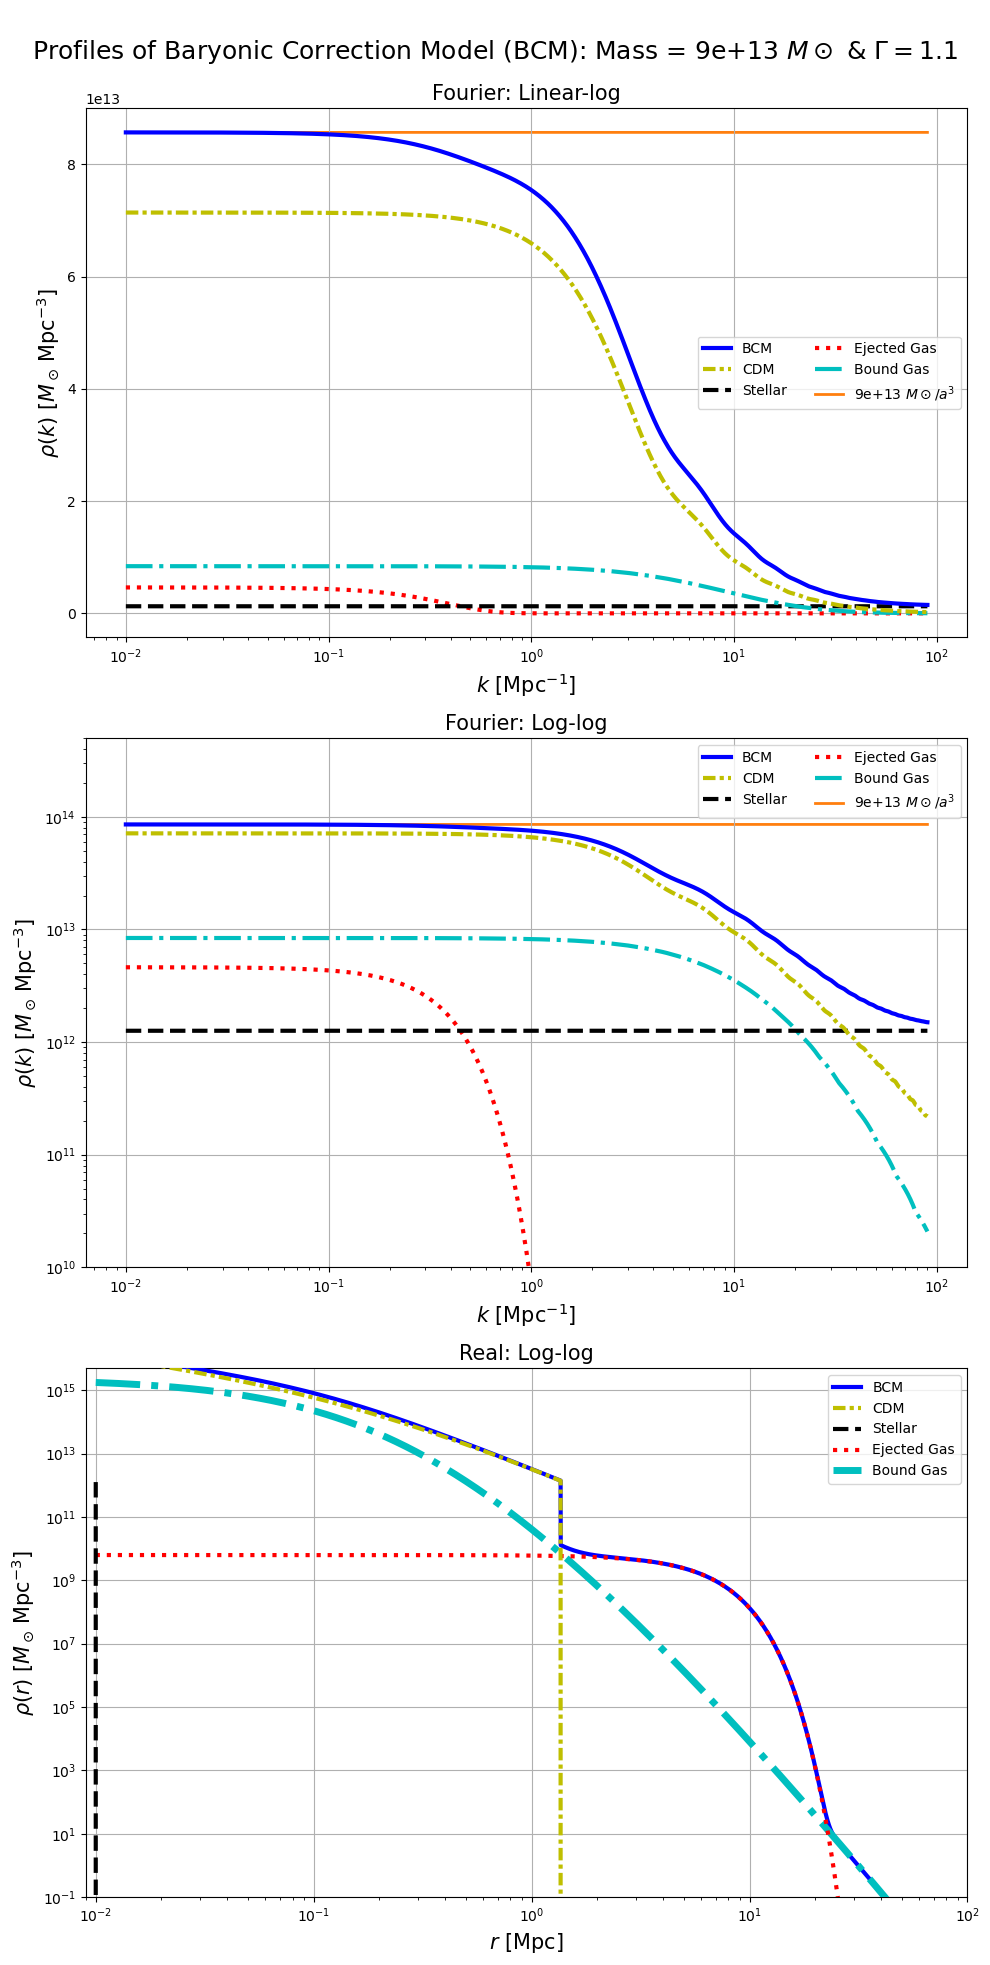

In [89]:
i = 1
title_combined = f'\nProfiles of Baryonic Correction Model (BCM): Mass = {trial_M[i]:.1g} $M \\odot$ & $\\Gamma = ${trial_gamma}\n' 
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,20))
fig.suptitle(title_combined, fontsize=18)

ax1.plot(trial_k, bcm_fourier[i], 'b-', 
         lw=3, zorder = 5, label='BCM')
ax1.plot(trial_k, cdm_fourier[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=6, label='CDM')
ax1.plot(trial_k, stel_fourier[i], 'k--', lw=3, zorder = 3, label='Stellar')
ax1.plot(trial_k, ej_fourier[i], 'r:', 
         lw=3, zorder = 2, label='Ejected Gas')
ax1.plot(trial_k, bd_fourier[0,i], 'c-.', 
         lw=3, zorder = 4, label='Bound Gas')
ax1.plot(trial_k, 1*trial_k + trial_M[i], 'tab:orange', zorder=1, lw=2, label=f'{trial_M[i]:.1g} $M \\odot /a^3$')
    
ax1.set_ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax1.set_xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
ax1.set_title('Fourier: Linear-log', fontsize=15)
ax1.grid(True)
ax1.legend(loc='best', ncol=2)
ax1.set_xscale('log'); 
##########################
ax2.plot(trial_k, bcm_fourier[i], 'b-', lw=3, zorder = 5, label='BCM')
ax2.plot(trial_k, cdm_fourier[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=6, label='CDM')
ax2.plot(trial_k, stel_fourier[i], 'k--', lw=3, zorder = 5, label='Stellar')
ax2.plot(trial_k, ej_fourier[i], 'r:', lw=3, zorder = 4, label='Ejected Gas')
ax2.plot(trial_k, bd_fourier[0,i], 'c-.', lw=3, zorder = 3, label='Bound Gas')
ax2.plot(trial_k, 1*trial_k + trial_M[i], 'tab:orange', zorder=1, lw=2, label=f'{trial_M[i]:.1g} $M \\odot /a^3$')
    
ax2.set_ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax2.set_xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
ax2.set_title('Fourier: Log-log', fontsize=15)
ax2.grid(True)
ax2.legend(loc='best', ncol=2)
ax2.set_xscale('log'); 
ax2.set_ylim(1E10, 5E14)
#ax2.set_ylim(5E10)
ax2.set_yscale('log');
#########################
ax3.plot(trial_r, bcm_real[i], 'b-', lw=3, zorder = 3, label='BCM')
ax3.plot(trial_r, cdm_real[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=7, label='CDM')
ax3.plot(trial_r, stel_real[i], 'k--', lw=3, zorder = 5, label='Stellar')
ax3.plot(trial_r, ej_real[i], 'r:', lw=3, zorder = 4, label='Ejected Gas')
ax3.plot(trial_r, bd_real[i], 'c-.', lw=5, zorder = 3, label='Bound Gas')
    
ax3.set_ylabel(r'$\rho(r)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax3.set_xlabel(r'$r\, \,[{\rm Mpc}]$', fontsize=15);
ax3.set_title('Real: Log-log', fontsize=15)
ax3.grid(True)
ax3.legend(loc='best')
ax3.set_xscale('log'); 
ax3.set_ylim(1E-1, 5E15)
ax3.set_xlim(9E-3, 1E2)
ax3.set_yscale('log');

fig.tight_layout();

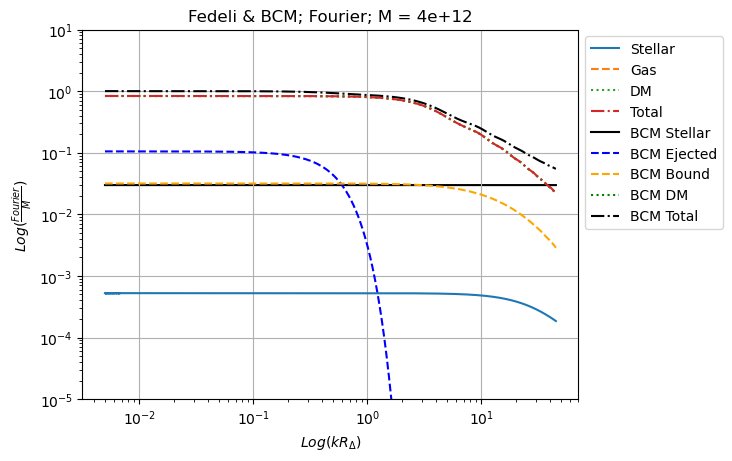

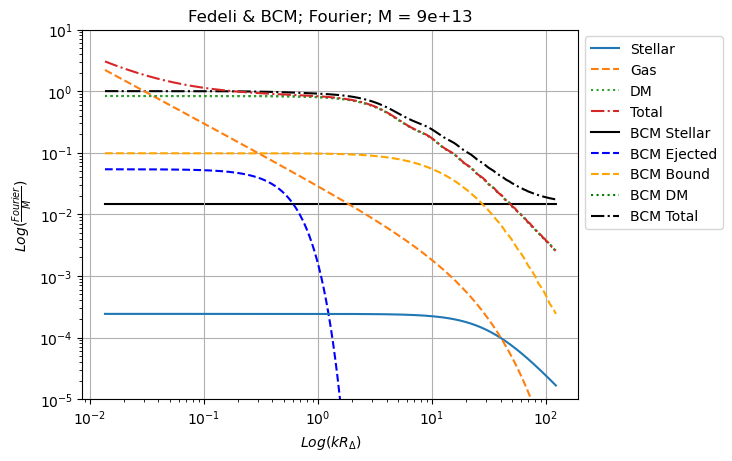

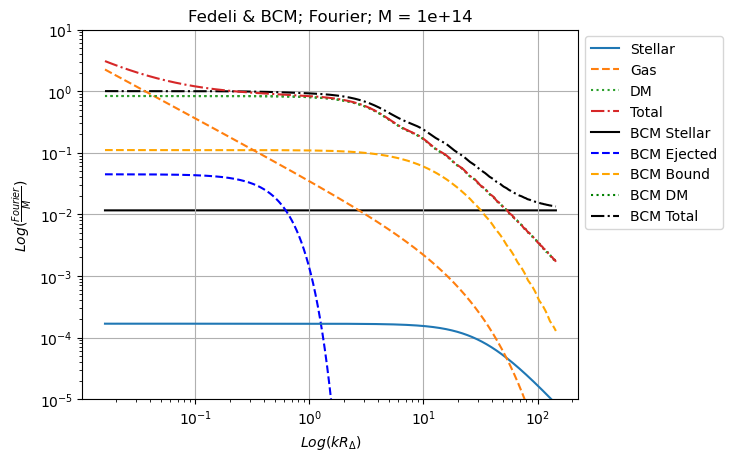

<Figure size 640x480 with 0 Axes>

In [91]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    r_Delta = trial_gasProf.mass_def.get_radius(cosmo, mass, 1) 
    # r_vir = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a
    plt.plot(trial_k*r_Delta, trial_stel_fourier[i]/mass, '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_k*r_Delta, trial_gas_fourier[i]/mass, '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_k*r_Delta, trial_dm_fourier[i]/mass, ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_k*r_Delta, trial_sum_fourier[i]/mass, '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_k*r_Delta, stel_fourier[i]/mass, 'k-', zorder=1, label='BCM Stellar');
    plt.plot(trial_k*r_Delta, ej_fourier[i]/mass, 'b--', zorder=2, label='BCM Ejected');
    plt.plot(trial_k*r_Delta, bd_fourier[0,i]/mass, '--', color='orange', zorder=3, label='BCM Bound');
    plt.plot(trial_k*r_Delta, cdm_fourier[i]/mass, 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_k*r_Delta, bcm_fourier[i]/mass, 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    #plt.ylim(9E3, 4E14)
    plt.ylim(1E-5, 1E1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$Log(k R_{\\Delta})$')
    plt.ylabel('$Log(\\frac{Fourier}{M})$')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure()

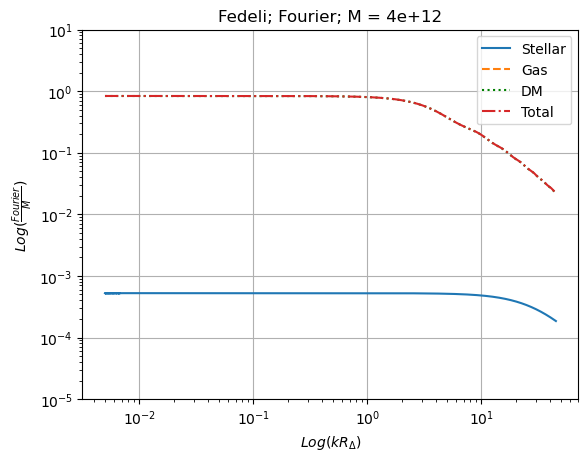

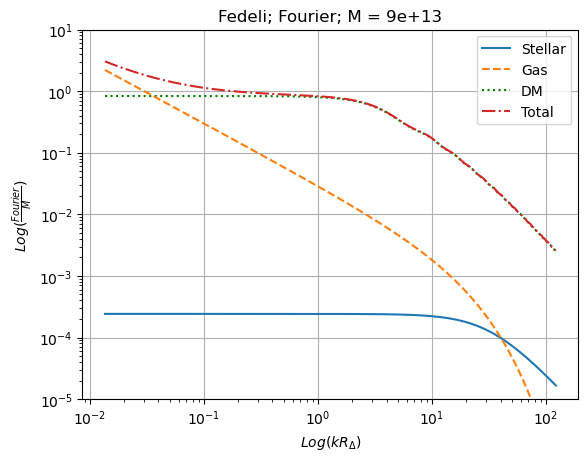

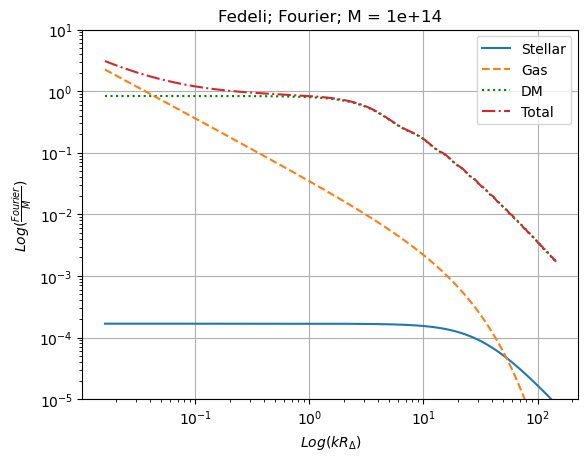

<Figure size 640x480 with 0 Axes>

In [97]:
colours = ['tab:blue', 'tab:orange', 'green', 'tab:red'] 
for i, mass in enumerate(trial_M):
    r_Delta = trial_gasProf.mass_def.get_radius(cosmo, mass, 1) 
    # r_vir = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a
    plt.plot(trial_k*r_Delta, trial_stel_fourier[i]/mass, '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_k*r_Delta, trial_gas_fourier[i]/mass, '--', color=colours[1], zorder=10, label='Gas');
    plt.plot(trial_k*r_Delta, trial_dm_fourier[i]/mass, ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_k*r_Delta, trial_sum_fourier[i]/mass, '-.', color=colours[3], zorder=9, label='Total');
    
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    plt.ylim(1E-5, 1E1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$Log(k R_{\\Delta})$')
    plt.ylabel('$Log(\\frac{Fourier}{M})$')
    plt.title(f'Fedeli; Fourier; M = {mass:.1g}');
    plt.figure()

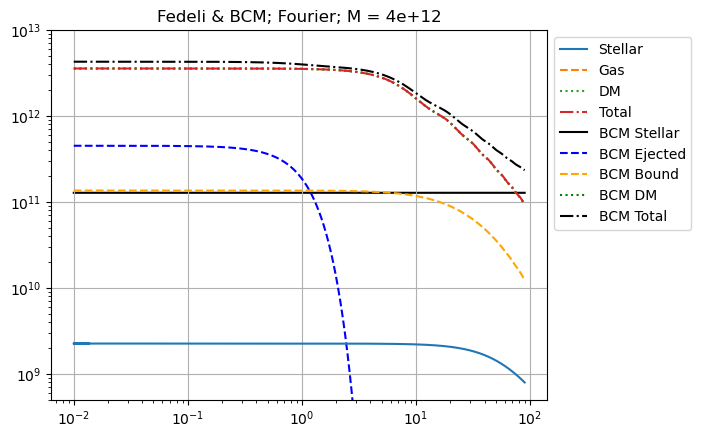

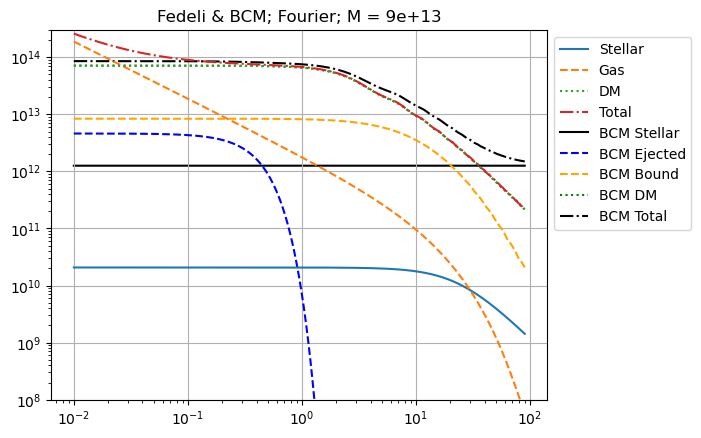

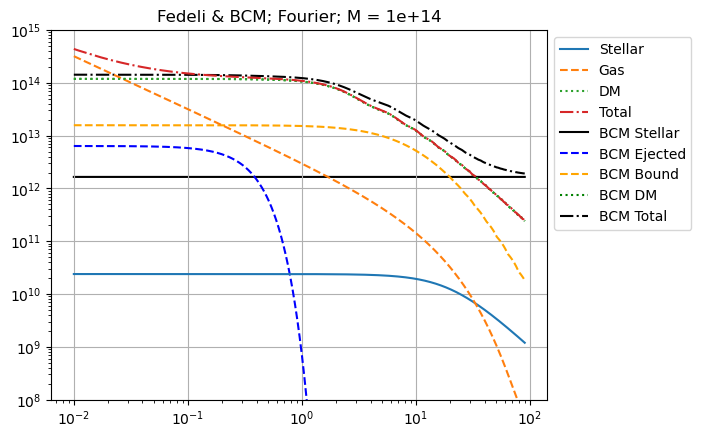

<Figure size 640x480 with 0 Axes>

In [98]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_k, trial_dm_fourier[i], ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_k, stel_fourier[i], 'k-', zorder=1, label='BCM Stellar');
    plt.plot(trial_k, ej_fourier[i], 'b--', zorder=2, label='BCM Ejected');
    plt.plot(trial_k, bd_fourier[0,i], '--', color='orange', zorder=3, label='BCM Bound');
    plt.plot(trial_k, cdm_fourier[i], 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_k, bcm_fourier[i], 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    ylim_upper, ylim_lower = [1E13, 3E14, 1E15], [5E8, 1E8, 1E8]
    plt.ylim(ylim_lower[i], ylim_upper[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

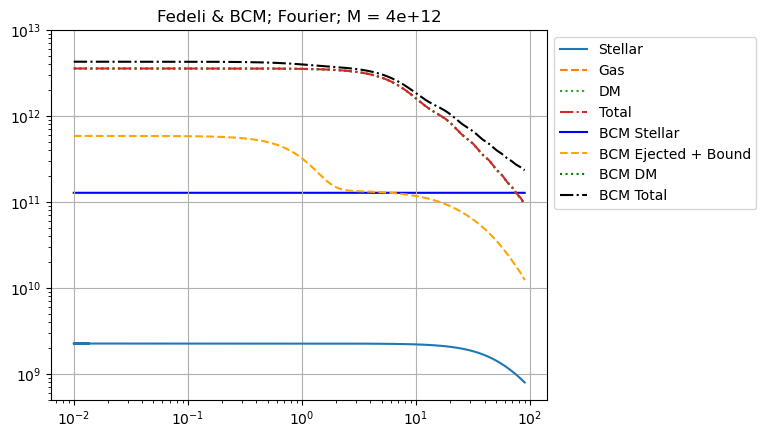

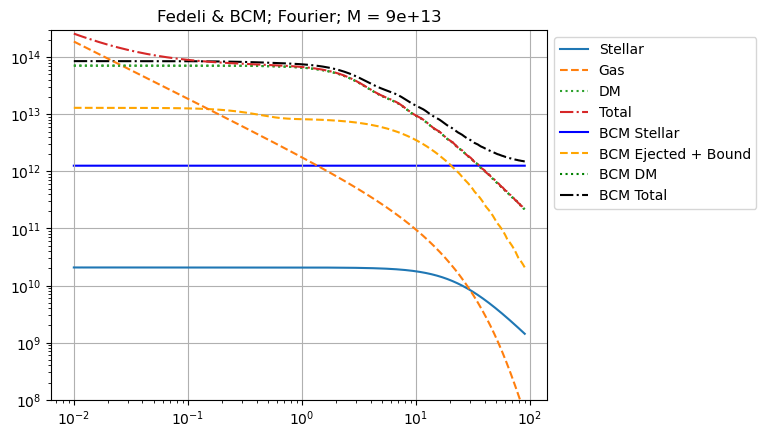

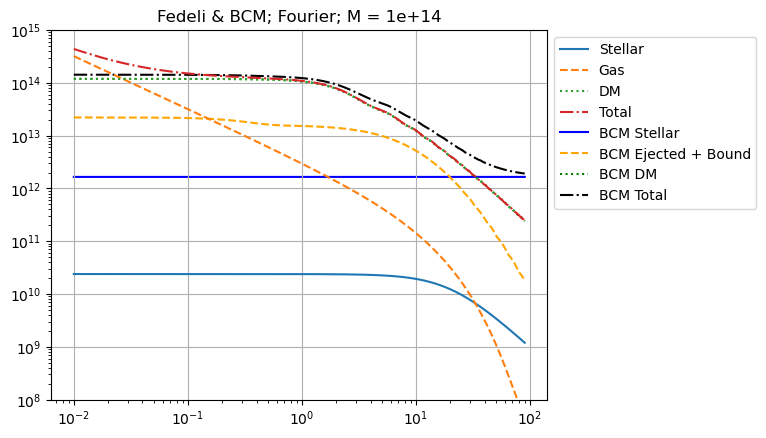

<Figure size 640x480 with 0 Axes>

In [101]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']

for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_k, trial_dm_fourier[i], ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_k, stel_fourier[i], 'b-', zorder=1, label='BCM Stellar');
    plt.plot(trial_k, ej_fourier[i]+bd_fourier[0,i], '--', color='orange', zorder=2, label='BCM Ejected + Bound');
    plt.plot(trial_k, cdm_fourier[i], 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_k, bcm_fourier[i], 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    ylim_upper, ylim_lower = [1E13, 3E14, 1E15], [5E8, 1E8, 1E8]
    plt.ylim(ylim_lower[i], ylim_upper[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

## Components

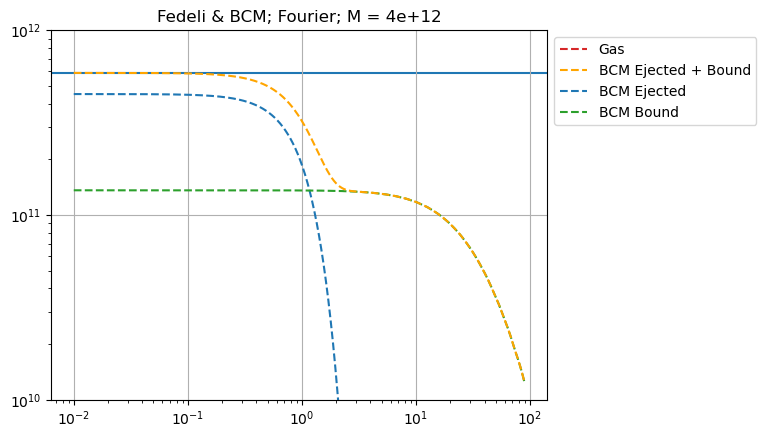

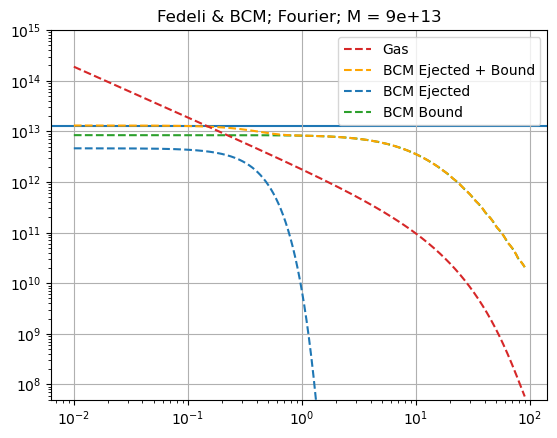

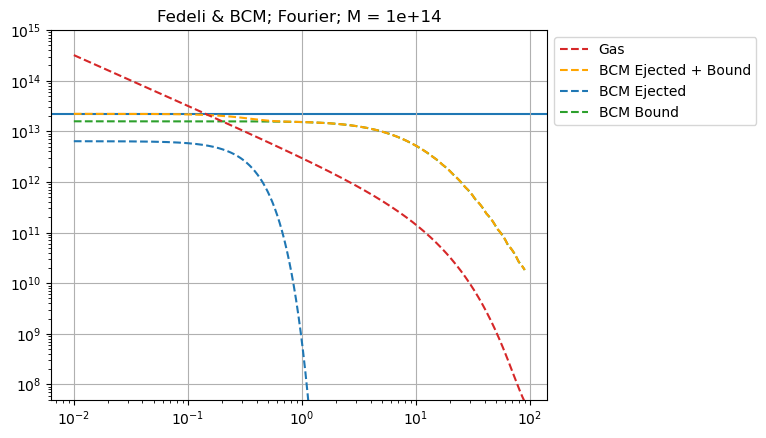

<Figure size 640x480 with 0 Axes>

In [103]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
ylim_plot = []
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[3], zorder=7, label='Gas');
    
    plt.plot(trial_k, ej_fourier[i]+bd_fourier[0,i], '--', color='orange', zorder=4, label='BCM Ejected + Bound');
    plt.plot(trial_k, ej_fourier[i], '--', color='tab:blue', zorder=2, label='BCM Ejected');
    plt.plot(trial_k, bd_fourier[0,i], '--', color='tab:green', zorder=3, label='BCM Bound');
    plt.axhline(mass*(bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1][i]), zorder=1)
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    ylim_upper, ylim_lower = [1E12, 1E15, 1E15], [1E10, 5E7, 5E7]
    plt.ylim(ylim_lower[i], ylim_upper[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

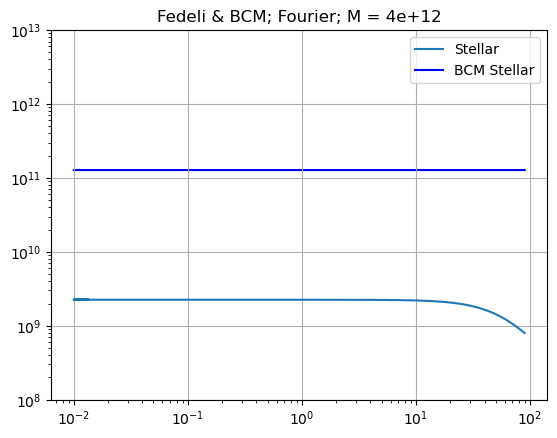

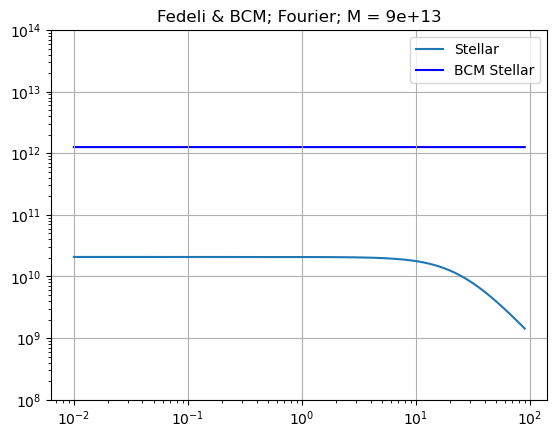

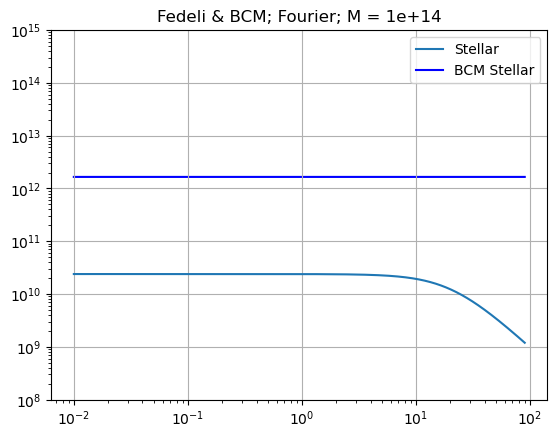

<Figure size 640x480 with 0 Axes>

In [104]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
    
    plt.plot(trial_k, stel_fourier[i], 'b-', zorder=1, label='BCM Stellar');
    plt.legend(loc='best')
    plt.grid(True)
    ylim_upper, ylim_lower = 1*10**(13+i), 1E8 #[1E4, 1E3, 1E3]
    plt.ylim(ylim_lower, ylim_upper)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

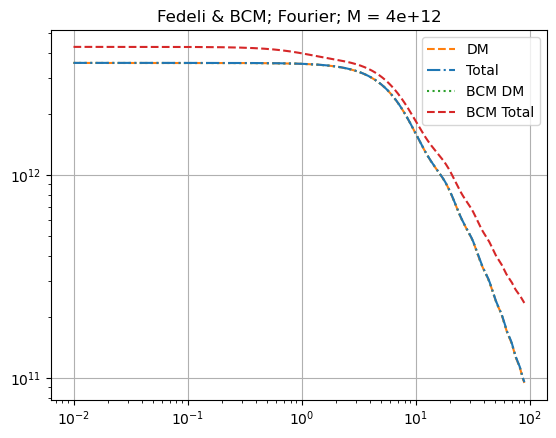

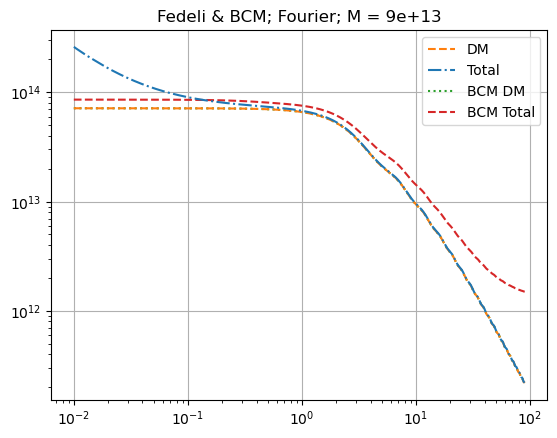

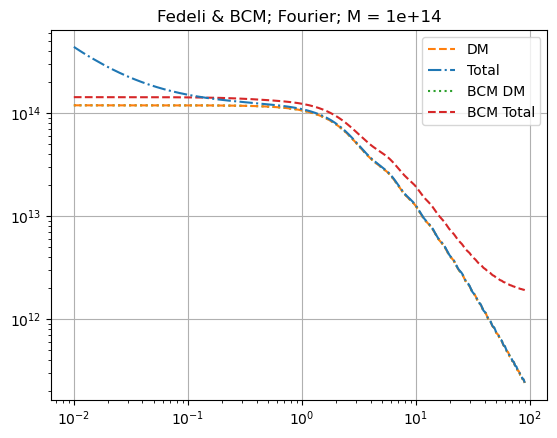

<Figure size 640x480 with 0 Axes>

In [106]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_dm_fourier[i], '--', color=colours[1], label='DM', zorder=8);
    plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[0], zorder=9, label='Total');
    
    plt.plot(trial_k, cdm_fourier[i], ':', color=colours[2], zorder=4, label='BCM DM');
    plt.plot(trial_k, bcm_fourier[i], '--', color=colours[3], zorder=5, label='BCM Total');
    plt.legend(loc='best')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

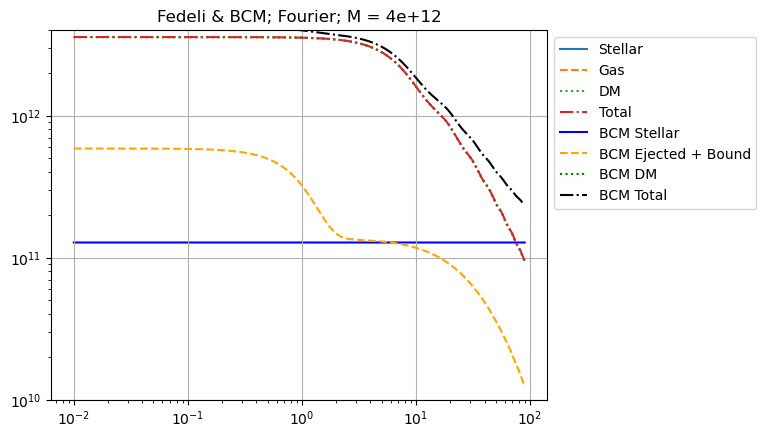

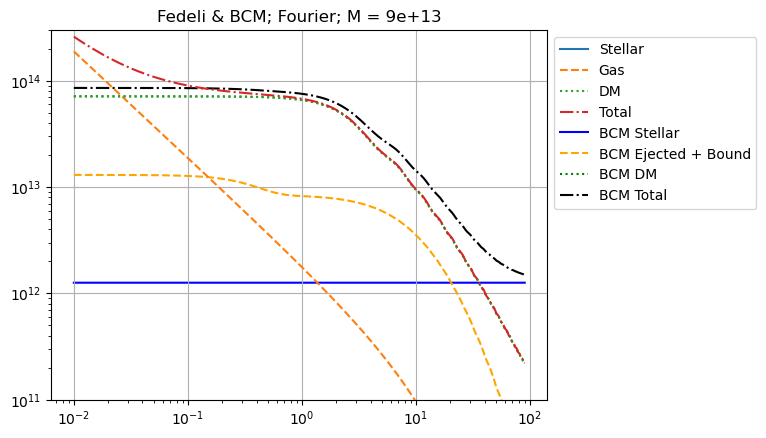

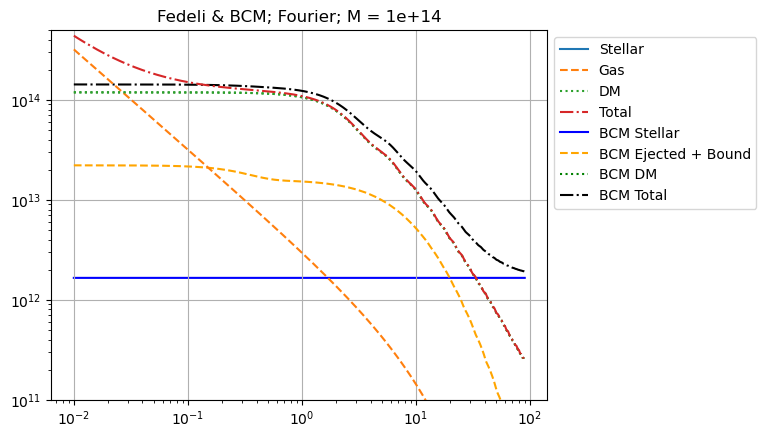

<Figure size 640x480 with 0 Axes>

In [110]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']

for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_k, trial_dm_fourier[i], ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_k, stel_fourier[i], 'b-', zorder=1, label='BCM Stellar');
    plt.plot(trial_k, ej_fourier[i]+bd_fourier[0,i], '--', color='orange', zorder=2, label='BCM Ejected + Bound');
    plt.plot(trial_k, cdm_fourier[i], 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_k, bcm_fourier[i], 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.grid(True)
    ylim_lower, ylim_upper = [1E10, 1E11, 1E11], [4E12, 3E14, 5E14]
    plt.ylim(ylim_lower[i], ylim_upper[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

### Comparing the real profiles

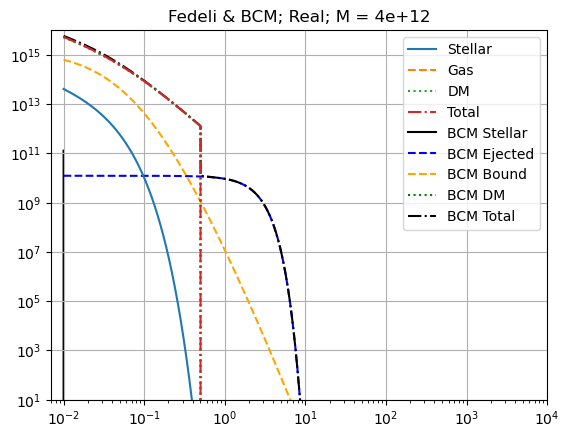

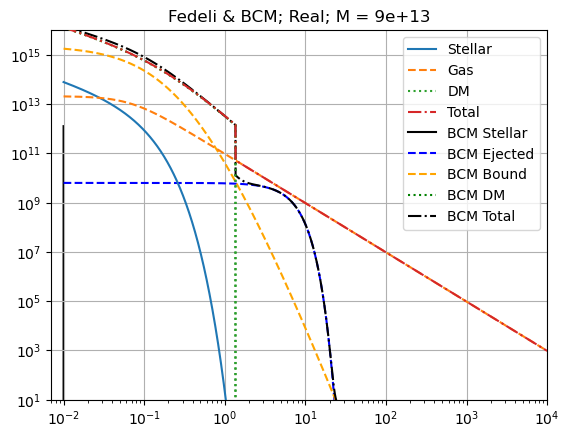

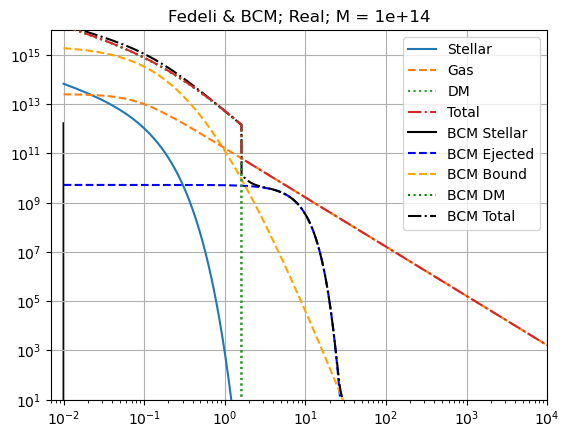

<Figure size 640x480 with 0 Axes>

In [112]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    plt.plot(trial_r, trial_stel_real[i], '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_r, trial_gas_real[i], '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_r, trial_dm_real[i], ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_r, trial_sum_real[i], '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_r, stel_real[i], 'k-', zorder=1, label='BCM Stellar');
    plt.plot(trial_r, ej_real[i], 'b--', zorder=2, label='BCM Ejected');
    plt.plot(trial_r, bd_real[i], '--', color='orange', zorder=3, label='BCM Bound');
    plt.plot(trial_r, cdm_real[i], 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_r, bcm_real[i], 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    plt.ylim(1E1, 1E16)
    plt.xlim(7E-3, 1E4)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Real; M = {mass:.1g}');
    plt.figure();

# Checking normalisations of profiles

In [114]:
print(f'For BCM\nf_cdm = {bcm_profile.f_c}')
print(f'f_* = {bcm_profile._f_bd(trial_M)[1]}') 
print(f'f_bd = {bcm_profile._f_bd(trial_M)[0]}') # f_bd, then f_stell
print(f'f_ej = {bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1] - bcm_profile._f_bd(trial_M)[0]}') 
print(f'f_gas = {bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1]}')

trial_stelProf
print(f'\nFor SAM (Fedeli 2014)\nf_cdm = {f_dm}')
print(f'f_* = {trial_stelProf._f_stell(trial_M)}')  
print(f'f_gas = {trial_gasProf._f_gas(trial_M)}')

For BCM
f_cdm = 0.8333333333333333
f_* = [0.02981898 0.01470412 0.01159136]
f_bd = [0.03169744 0.09805594 0.11040291]
f_ej = [0.10515024 0.05390661 0.0446724 ]
f_gas = [0.13684768 0.15196255 0.15507531]

For SAM (Fedeli 2014)
f_cdm = 0.8333333333333333
f_* = [0.02288351 0.01553537 0.01293284]
f_gas = [0.         0.13276092 0.14579879]


In [ ]:
# trial_M, trial_stel_real, trial_gas_real, trial_dm_real
# trial_sum_real = trial_stel_real + trial_gas_real + trial_dm_real
# trial_sum_fourier = trial_stel_fourier + trial_gas_fourier + trial_dm_fourier

# cdm_real , stel_real , ej_real , bd_real , bcm_real

In [116]:
print('Should get:  $4 \\pi \\int^{\\infty}_0 r^2 g(r) dr = 1 $, when normalised by (respective) mass')
print('With BCM: \n')
print('bound: ', integrate.simpson(4*np.pi*(trial_r**2)*bd_real, x = trial_r)/(trial_M*bcm_profile._f_bd(trial_M)[0]))
print('stellar: ', integrate.simpson(4*np.pi*(trial_r**2)*stel_real, x = trial_r)/(trial_M*bcm_profile._f_bd(trial_M)[1]))
trial_f_ej = bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1] - bcm_profile._f_bd(trial_M)[0]
print('ejected: ', integrate.simpson(4*np.pi*(trial_r**2)*ej_real, x = trial_r)/(trial_M*trial_f_ej))
print('dark matter: ', integrate.simpson(4*np.pi*(trial_r**2)*cdm_real, x = trial_r)/(trial_M*bcm_profile.f_c))

#### Note: stellar is not correct, but this was already known about / matches previous behaviour

print('\nWith Fedeli 2014: \n')
print('gas: ', integrate.simpson(4*np.pi*(trial_r**2)*trial_gas_real, x = trial_r)/(trial_M*trial_gasProf._f_gas(trial_M)))
print('stellar: ', integrate.simpson(4*np.pi*(trial_r**2)*trial_stel_real, x = trial_r)/(trial_M*trial_stelProf._f_stell(trial_M)))
print('dark matter: ', integrate.simpson(4*np.pi*(trial_r**2)*trial_dm_real, x = trial_r)/(trial_M*f_dm))

# With Fedeli, only dm = correct (& it is the nfw profile) => gas & then stellar

Should get:  $4 \pi \int^{\infty}_0 r^2 g(r) dr = 1 $, when normalised by (respective) mass
With BCM: 

bound:  [0.97513386 0.99850429 0.99892551]
stellar:  [9.64514191e-10 9.64514191e-10 9.64514191e-10]
ejected:  [0.99999989 0.99999999 1.        ]
dark matter:  [0.98977999 0.99877063 0.99921502]

With Fedeli 2014: 

gas:  [              nan 10575940.07336348  9796097.09090712]
stellar:  [0.01958674 0.01513768 0.01269133]
dark matter:  [0.98977999 0.99877063 0.99921502]


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4061/2730421160.py:12: RuntimeWarning: invalid value encountered in divide
  print('gas: ', integrate.simpson(4*np.pi*(trial_r**2)*trial_gas_real, x = trial_r)/(trial_M*trial_gasProf._f_gas(trial_M)))


In [118]:
print('Seeing what integration looks like without normalisation for Fedeli 2014: \n')
print('gas: ', integrate.simpson(4*np.pi*(trial_r**2)*trial_gas_real, x = trial_r))
print('stellar: ', integrate.simpson(4*np.pi*(trial_r**2)*trial_stel_real, x = trial_r))
print('dark matter: ', integrate.simpson(4*np.pi*(trial_r**2)*trial_dm_real, x = trial_r))

Seeing what integration looks like without normalisation for Fedeli 2014: 

gas:  [0.00000000e+00 1.20348987e+20 2.04037020e+20]
stellar:  [1.92091409e+09 2.01573772e+10 2.34478501e+10]
dark matter:  [3.53492855e+12 7.13407590e+13 1.18954169e+14]
